In [1]:
import numpy as np 
import pandas as pd 
from scipy.ndimage import gaussian_filter
from skimage.feature import blob_log
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu as thresh_func

In [2]:
flo_image_1 = np.load(r'timeseriesbrain\flo_image_1.npz')
flo_image_2 = np.load(r'timeseriesbrain\flo_image_2.npz')

In [3]:
images_ids = np.concatenate([flo_image_1['image_ids'], flo_image_2['image_ids']])
images = np.concatenate([flo_image_1['image_stack'], flo_image_2['image_stack']])

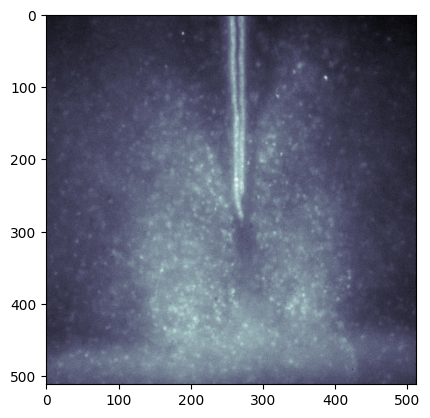

In [4]:
plt.imshow(images[0], cmap='bone')


In [5]:
image_dict = dict(zip(images_ids, images))

In [6]:
def preprocess(images, p1=1., p2=99., std1=1.5, std2=16.):
    """
    First normalizes around zero by subtracting a gaussian filter, then clipping the p1,p2 percentiles.
    The result will have float values between 0 and 1.
    """

    #We want to see neurons in contrast with their surroundings, 
    #and for now we don't care about non-local features.
    # images = (gaussian_filter(images, sigma=(0,std1,std1)) -
    #           gaussian_filter(images, sigma=(0,std2,std2)))

    
    #We run a loop over time - doing clip vectorised crashes the computer for some reason.
    for time in range(images.shape[0]):
        lo = np.percentile(images[time], p1)
        hi = np.percentile(images[time], p2)
        images[time] = (np.clip(images[time], lo, hi) - lo) / (hi - lo)
    return images

In [7]:
time_df = pd.read_csv('timeseriesbrain\data141110.csv')
time_df['path'] = time_df['Image.No.'].map(lambda x: "141110A3.%04d" % (x))
time_df['loaded'] = time_df['path'].map(lambda x: x in image_dict)
print(time_df.value_counts('loaded'))
valid_time_df = time_df.query('loaded')
valid_time_df.sample(3)

loaded
True    1685
dtype: int64


,Image.No.,Frame.No,Time.hrs.,path,loaded
1002,1052,1003,103.816306,141110A3.1052,True
413,463,414,44.916306,141110A3.0463,True
843,893,844,87.916306,141110A3.0893,True


In [8]:
bg_image2 = np.max(flo_image_2['image_stack'])

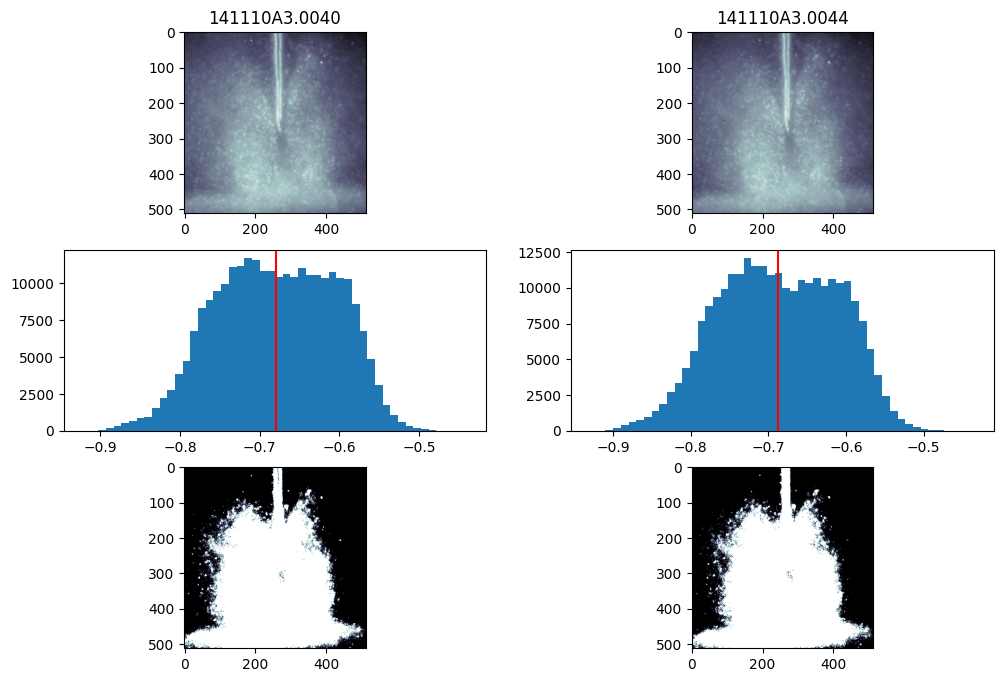

In [9]:
fig, m_axs = plt.subplots(3,2, figsize = (12, 8))
for (ax1, ax2, ax3), (img_name, rimg_data) in  zip(m_axs.T, image_dict.items()):
    img_data =np.log10(rimg_data/bg_image2)
    ax1.imshow(img_data, cmap = 'bone')
    ax1.set_title(img_name)
    thresh_val = thresh_func(img_data)
    ax2.hist(img_data.ravel(),50)
    ax2.axvline(thresh_val, color='r')
    ax3.imshow(img_data>thresh_val, cmap = 'bone')

In [10]:
testimg = list(image_dict.values())[0]

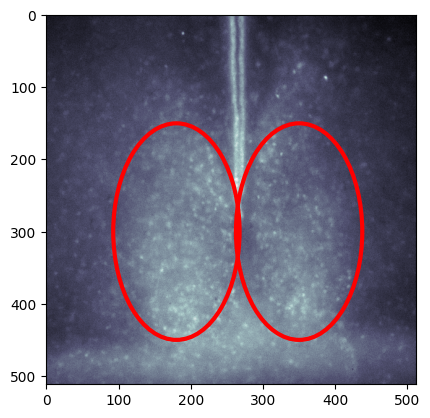

In [11]:
from matplotlib.patches import Ellipse
fig, ax = plt.subplots()
plt.imshow(testimg, cmap='bone')
l = Ellipse((180,300), 175,300, color='r', fill=False, lw=3)
ax.add_patch(l)
r = Ellipse((350,300), 175,300, color='r', fill=False, lw=3)
ax.add_patch(r)

plt.savefig('regionsofinterest.png')

In [12]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt(((X - center[0])*3)**2 + (((Y-center[1])*1.714)**2))

    mask = dist_from_center <= radius
    return mask

In [13]:
mask1 = create_circular_mask(512, 512, center=(170, 300), radius=300)

In [14]:
mask2 = create_circular_mask(512, 512, center=(360, 300), radius=300)

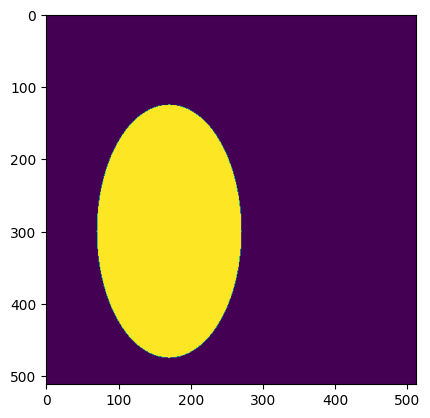

In [15]:
plt.imshow(mask1)

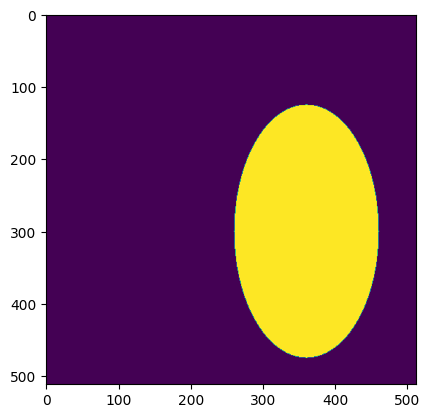

In [16]:
plt.imshow(mask2)

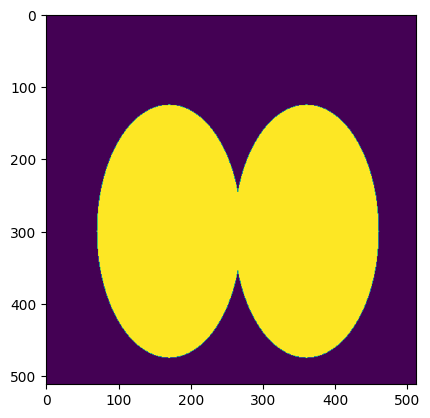

In [17]:
fullmask = mask1 | mask2

plt.imshow(fullmask)
plt.savefig('mask.png')

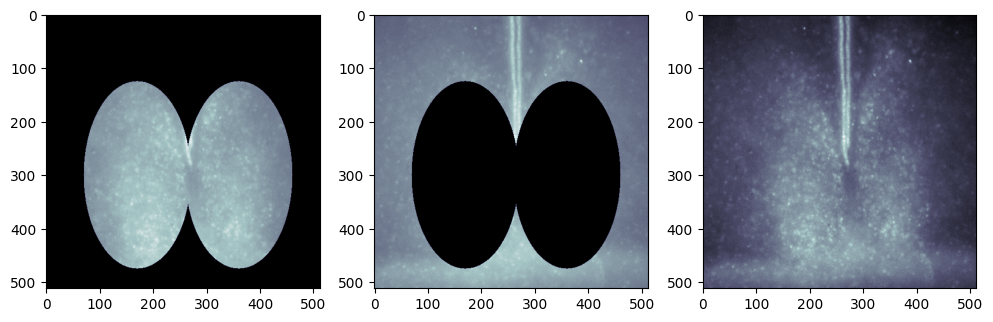

In [18]:
fig,ax = plt.subplots(1,3, figsize = (12, 8))

ax[0].imshow(testimg*fullmask, cmap='bone')
ax[1].imshow(testimg*~fullmask, cmap='bone')
ax[2].imshow(testimg, cmap='bone')

In [19]:
# plt.imshow(list(map(lambda x: x*fullmask, image_dict.values())))




In [20]:



images = (list(map(lambda x: x*fullmask, image_dict.values())))




In [21]:
testimg = images[0]

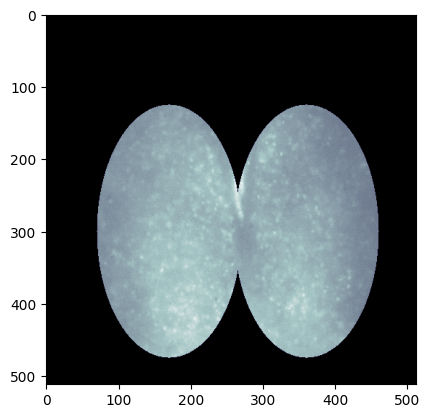

In [22]:
plt.imshow(testimg, cmap='bone')
# plt.savefig('cropped_brain.png')





In [23]:
ids = list(image_dict.keys())

In [24]:
header = ['time.hrs', 'intensity.rfu']

In [25]:
intensity = list(map(lambda x: np.mean(x), images))

In [26]:
valid_time_df['Intensity.rfu'] = intensity 

valid_time_df # Add the intensity to the dataframe

,Image.No.,Frame.No,Time.hrs.,path,loaded,Intensity.rfu
0,40,1,3.750892,141110A3.0040,True,1133.455830
1,44,2,3.846050,141110A3.0044,True,1116.634602
2,45,3,3.946050,141110A3.0045,True,1110.413681
3,46,4,4.046050,141110A3.0046,True,1092.359589
4,47,5,4.146050,141110A3.0047,True,1087.382572
...,...,...,...,...,...,...
1680,1730,1681,171.616306,141110A3.1730,True,1401.839668
1681,1731,1682,171.716306,141110A3.1731,True,1403.830452
1682,1732,1683,171.816306,141110A3.1732,True,1403.874313
1683,1733,1684,171.916306,141110A3.1733,True,1402.563362


In [27]:
submissions = valid_time_df[['Time.hrs.', 'Intensity.rfu']]
submissions.to_csv('SCNonlyintensity.csv')